# Movie Recommendation System - Step by Step Development

## Development Approach
We'll build this systematically by:
1. **Exploring the data** - Understanding what we have
2. **Cleaning and preprocessing** - Preparing data for algorithms  
3. **Building 3 recommendation systems** - Each solving different problems
4. **Testing and comparing** - Validating our approaches

## Expected Outcomes
- **Popularity-Based**: For new users and trending content
- **Content-Based**: For users who know what they like
- **Collaborative Filtering**: For personalized recommendations

## Step 1: Setup and Data Loading

Let's start by importing libraries and loading our data to see what we're working with.

In [51]:
# Essential libraries for our recommendation system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Load our datasets
movies_df = pd.read_csv('../data/raw/movies.csv')
ratings_df = pd.read_csv('../data/raw/ratings.csv')

In [53]:
# Examine movies data structure
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [109]:
# Movie info
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [55]:
# Examine ratings data structure
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [56]:
# Ratings dataset basic info  
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


## Step 2: Key Data Insights

Now let's understand our data better - this will guide how we build our recommendation systems.

In [57]:
# Calculate key statistics for recommendation strategy
total_possible_ratings = movies_df['movieId'].nunique() * ratings_df['userId'].nunique()
actual_ratings = len(ratings_df)
sparsity = (1 - actual_ratings / total_possible_ratings) * 100

# Display key insights as DataFrame
pd.DataFrame({
    'Metric': ['Total Movies', 'Total Users', 'Total Ratings', 'Average Rating', 'Data Sparsity (%)'],
    'Value': [
        movies_df['movieId'].nunique(),
        ratings_df['userId'].nunique(), 
        len(ratings_df),
        round(ratings_df['rating'].mean(), 2),
        round(sparsity, 1)
    ]
})

,Metric,Value
0,Total Movies,10329.00
1,Total Users,668.00
2,Total Ratings,105339.00
3,Average Rating,3.52
4,Data Sparsity (%),98.50


In [58]:
# Check for missing values
movies_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [59]:
ratings_df.isnull().sum()


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

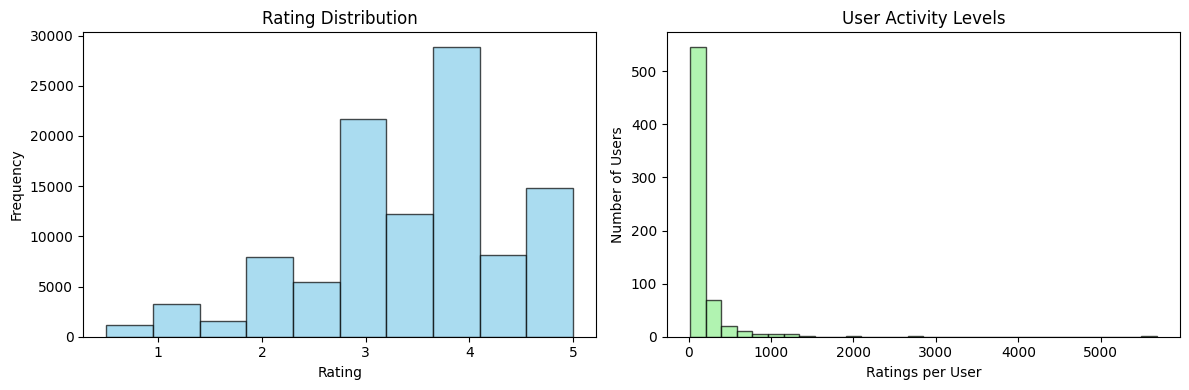

In [60]:
# Visualize key patterns in the data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rating distribution
axes[0].hist(ratings_df['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

# User activity levels
user_activity = ratings_df['userId'].value_counts()
axes[1].hist(user_activity, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('User Activity Levels')
axes[1].set_xlabel('Ratings per User')
axes[1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

In [61]:
# Calculate user and movie activity statistics
user_rating_counts = ratings_df['userId'].value_counts()
movie_rating_counts = ratings_df['movieId'].value_counts()

# Display activity statistics
pd.DataFrame({
    'Statistic': [
        'Most active user (ratings)',
        'Most rated movie (ratings)', 
        'Average ratings per user',
        'Average ratings per movie'
    ],
    'Value': [
        user_rating_counts.max(),
        movie_rating_counts.max(),
        round(user_rating_counts.mean(), 2),
        round(movie_rating_counts.mean(), 2)
    ]
})

,Statistic,Value
0,Most active user (ratings),5678.00
1,Most rated movie (ratings),325.00
2,Average ratings per user,157.69
3,Average ratings per movie,10.20


In [62]:
# Extract and analyze genres for content-based recommendations
all_genres = []
for genres_str in movies_df['genres'].dropna():
    genres = genres_str.split('|')
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts()

# Display genre summary
pd.DataFrame({
    'Metric': ['Total unique genres', 'Most common genre', 'Movies in most common genre'],
    'Value': [len(genre_counts), genre_counts.index[0], genre_counts.iloc[0]]
})

,Metric,Value
0,Total unique genres,20
1,Most common genre,Drama
2,Movies in most common genre,5220


In [63]:
# Top 10 genres by number of movies
top_10_genres = genre_counts.head(10)
top_10_genres.to_frame('Number of Movies')

,Number of Movies
Drama,5220
Comedy,3515
Thriller,2187
Romance,1788
Action,1737
Crime,1440
Adventure,1164
Horror,1001
Sci-Fi,860
Mystery,675


In [64]:
# Calculate genre-level statistics
def get_genre_stats():
    """Calculate average rating and total movies for each genre"""
    genre_stats = {}
    
    for genre in genre_counts.index:
        # Find movies with this genre
        genre_movies = movies_df[movies_df['genres'].str.contains(genre, na=False)]
        # Get ratings for these movies
        genre_ratings = ratings_df[ratings_df['movieId'].isin(genre_movies['movieId'])]
        
        if len(genre_ratings) > 0:
            genre_stats[genre] = {
                'avg_rating': genre_ratings['rating'].mean(),
                'total_movies': len(genre_movies),
                'total_ratings': len(genre_ratings)
            }
    
    return pd.DataFrame(genre_stats).T

genre_stats_df = get_genre_stats()
genre_stats_df = genre_stats_df.sort_values('avg_rating', ascending=False)

# Show top 10 genres by average rating
genre_stats_df.head(10).round(1)

,avg_rating,total_movies,total_ratings
Film-Noir,3.9,195.0,1210.0
War,3.8,503.0,5828.0
Mystery,3.7,675.0,8320.0
Drama,3.7,5220.0,46960.0
Documentary,3.6,415.0,1206.0
Crime,3.6,1440.0,18291.0
IMAX,3.6,152.0,3032.0
Animation,3.6,401.0,5966.0
Musical,3.6,409.0,4287.0
Western,3.6,235.0,2314.0


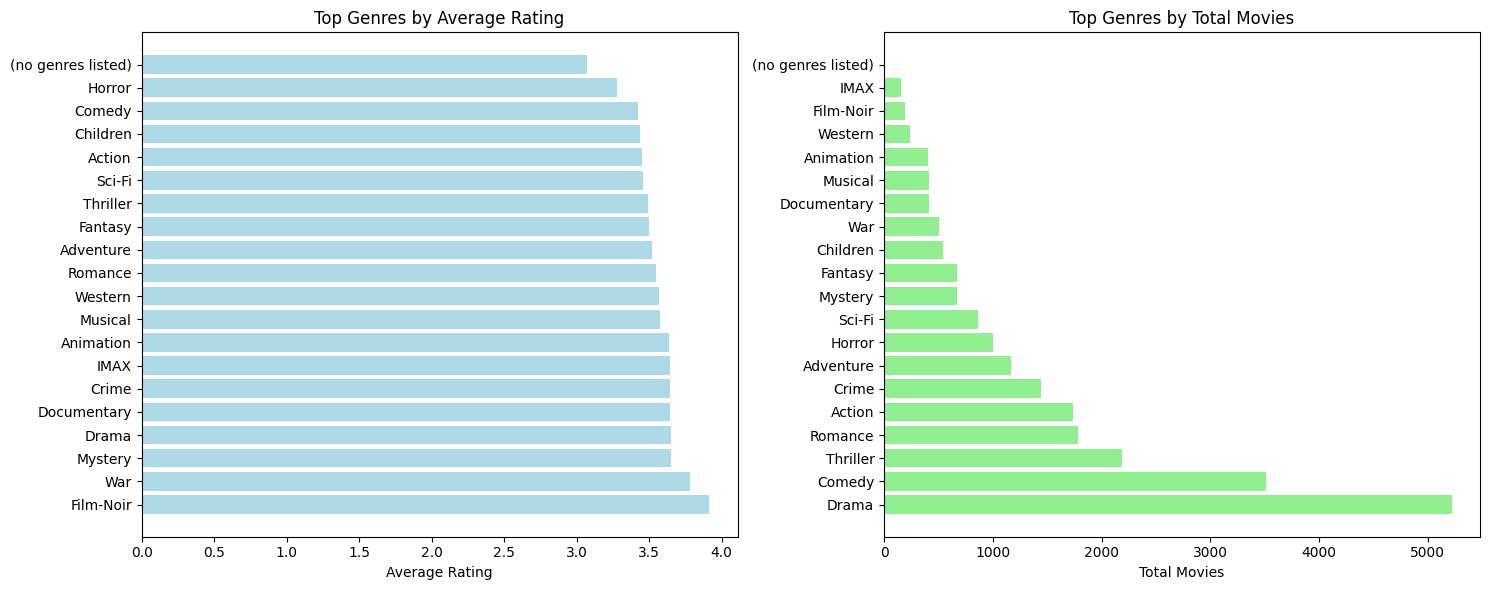

In [65]:
# Visualize genre statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average rating by genre
top_genres = genre_stats_df
axes[0].barh(range(len(top_genres)), top_genres['avg_rating'], color='lightblue')
axes[0].set_yticks(range(len(top_genres)))
axes[0].set_yticklabels(top_genres.index)
axes[0].set_xlabel('Average Rating')
axes[0].set_title('Top Genres by Average Rating')

# Total movies by genre
top_movie_genres = genre_stats_df.sort_values('total_movies', ascending=False)
axes[1].barh(range(len(top_movie_genres)), top_movie_genres['total_movies'], color='lightgreen')
axes[1].set_yticks(range(len(top_movie_genres)))
axes[1].set_yticklabels(top_movie_genres.index)
axes[1].set_xlabel('Total Movies')
axes[1].set_title('Top Genres by Total Movies')

plt.tight_layout()
plt.show()

# Step 3: Building Recommendation Algorithms

Now that we understand our data, let's build three different types of recommendation systems:

## 1. Popularity-Based Recommendations
**The Logic**: Recommend movies that are generally well-liked and popular
- Good for new users (cold start problem)
- Simple but effective baseline

## 2. Collaborative Filtering  
**The Logic**: "Users who liked similar movies as you also liked these"
- Finds users with similar tastes
- Recommends movies those similar users rated highly

## 3. Content-Based Filtering
**The Logic**: "Since you liked Movie X, here are similar movies"  
- Uses movie features (genres) to find similarities
- Good when we have movie metadata

Let's implement each one step by step...

In [66]:
# Prepare data for content-based recommendations
def create_genre_features(movies_df):
    """Convert pipe-separated genres into binary columns"""
    # Get all unique genres
    all_genres = set()
    for genres_str in movies_df['genres'].dropna():
        all_genres.update(genres_str.split('|'))
    
    # Create binary columns
    movies_expanded = movies_df.copy()
    for genre in sorted(all_genres):
        movies_expanded[f'genre_{genre}'] = movies_expanded['genres'].str.contains(genre, na=False).astype(int)
    
    return movies_expanded, sorted(all_genres)

movies_with_genres, unique_genres = create_genre_features(movies_df)

# Show preparation results
pd.DataFrame({
    'Metric': ['Genre columns created', 'Dataset shape (rows)', 'Dataset shape (cols)'],
    'Value': [len(unique_genres), movies_with_genres.shape[0], movies_with_genres.shape[1]]
})

,Metric,Value
0,Genre columns created,20
1,Dataset shape (rows),10329
2,Dataset shape (cols),23


In [67]:
def get_popular_recommendations(genre=None, min_ratings=50, top_n=10):
    """
    Popularity-based recommendations
    """
    # Calculate movie statistics
    movie_stats = ratings_df.groupby('movieId').agg({
        'rating': ['mean', 'count']
    }).round(1)
    movie_stats.columns = ['avg_rating', 'num_ratings']
    movie_stats = movie_stats.reset_index()
    
    # Merge with movie info
    movies_with_stats = movies_df.merge(movie_stats, on='movieId')
    
    # Apply filters
    filtered_movies = movies_with_stats[movies_with_stats['num_ratings'] >= min_ratings]
    
    if genre:
        filtered_movies = filtered_movies[filtered_movies['genres'].str.contains(genre, case=False, na=False)]
    
    # Sort by rating and return top N
    top_movies = filtered_movies.nlargest(top_n, 'avg_rating')
    
    return top_movies[['title', 'genres', 'avg_rating', 'num_ratings']].reset_index(drop=True)

In [68]:
# Test popularity-based recommendations
get_popular_recommendations(genre="Action", min_ratings=100, top_n=5)

,title,genres,avg_rating,num_ratings
0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.3,261
1,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.2,273
2,Blade Runner (1982),Action|Sci-Fi|Thriller,4.2,156
3,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.2,228
4,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.2,171


In [69]:
get_popular_recommendations(genre="Drama", min_ratings=200, top_n=5)

,title,genres,avg_rating,num_ratings
0,"Shawshank Redemption, The (1994)",Crime|Drama,4.5,308
1,"Godfather, The (1972)",Crime|Drama,4.4,210
2,Schindler's List (1993),Drama|War,4.3,248
3,Fargo (1996),Comedy|Crime|Drama|Thriller,4.3,201
4,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.2,325


In [70]:
# Prepare user-movie matrix for collaborative filtering
user_movie_matrix = ratings_df.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
)

# Fill missing values with user's average rating
user_movie_matrix_filled = user_movie_matrix.T.fillna(user_movie_matrix.mean(axis=1)).T

# Show matrix dimensions
pd.DataFrame({
    'Metric': ['Users', 'Movies', 'Sparsity (%)'],
    'Value': [
        user_movie_matrix.shape[0],
        user_movie_matrix.shape[1], 
        round((user_movie_matrix.isnull().sum().sum() / user_movie_matrix.size) * 100, 1)
    ]
})

,Metric,Value
0,Users,668.0
1,Movies,10325.0
2,Sparsity (%),98.5


In [71]:
movies_with_genres.head()

,movieId,title,genres,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [73]:
# Create user-movie matrix for collaborative filtering
user_movie_matrix = ratings_df.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
)

# Fill missing values with 0 (meaning "not rated")
user_movie_matrix_filled = user_movie_matrix.fillna(0)

# Show matrix information
sample_user = user_movie_matrix_filled.iloc[0]
rated_movies = (sample_user > 0).sum()

pd.DataFrame({
    'Metric': ['Matrix shape (users)', 'Matrix shape (movies)', 'Missing values', 'Example user rated movies'],
    'Value': [user_movie_matrix.shape[0], user_movie_matrix.shape[1], 
             user_movie_matrix.isnull().sum().sum(), rated_movies]
})

,Metric,Value
0,Matrix shape (users),668
1,Matrix shape (movies),10325
2,Missing values,6791761
3,Example user rated movies,113


In [74]:
user_movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Check filled matrix sample
user_movie_matrix_filled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
user_movie_matrix_filled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Calculate movie statistics for popularity-based recommendations
movie_stats = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).round(1)

# Simplify column names
movie_stats.columns = ['avg_rating', 'num_ratings']
movie_stats = movie_stats.reset_index()

# Merge with movie info
movies_with_stats = movies_df.merge(movie_stats, on='movieId', how='left')
movies_with_stats = movies_with_stats.fillna(0)  # Movies with no ratings

# Show most popular movie
most_popular = movies_with_stats.loc[movies_with_stats['num_ratings'].idxmax()]

pd.DataFrame({
    'Metric': ['Movies with statistics', 'Most rated movie', 'Most rated movie ratings', 'Most rated movie avg rating'],
    'Value': [len(movies_with_stats), most_popular['title'], int(most_popular['num_ratings']), most_popular['avg_rating']]
})

,Metric,Value
0,Movies with statistics,10329
1,Most rated movie,Pulp Fiction (1994)
2,Most rated movie ratings,325
3,Most rated movie avg rating,4.2


## Step 4: Building Recommendation System #1 - Popularity Based

**Strategy**: Recommend highly-rated movies within specific genres
**Best for**: New users, trending content discovery
**Algorithm**: Sort by average rating + minimum review threshold

In [78]:
movies_with_stats.head()

,movieId,title,genres,avg_rating,num_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.9,232.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.4,92.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.2,58.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.8,11.0
4,5,Father of the Bride Part II (1995),Comedy,3.2,62.0


In [79]:
# filter drama type genres movie
genre_movies = movies_with_stats[movies_with_stats['genres'].str.contains('Drama', case=False, na=False)]
genre_movies.head()

,movieId,title,genres,avg_rating,num_ratings
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.8,11.0
10,11,"American President, The (1995)",Comedy|Drama|Romance,3.7,85.0
13,14,Nixon (1995),Drama,3.5,25.0
15,16,Casino (1995),Crime|Drama,3.8,84.0
16,17,Sense and Sensibility (1995),Drama|Romance,3.9,100.0


In [80]:
# filer the min rating as 3 
popular_movies = genre_movies[genre_movies['num_ratings'] >= 3]
popular_movies.head()

,movieId,title,genres,avg_rating,num_ratings
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.8,11.0
10,11,"American President, The (1995)",Comedy|Drama|Romance,3.7,85.0
13,14,Nixon (1995),Drama,3.5,25.0
15,16,Casino (1995),Crime|Drama,3.8,84.0
16,17,Sense and Sensibility (1995),Drama|Romance,3.9,100.0


In [95]:
def get_popularity_based_recommendations(genre, min_reviews, top_n):
    """
    Popularity-based recommendation system
    
    Input: Genre filter, quality threshold, number wanted
    Output: Top N popular movies in that genre
    """
    # Filter by genre
    genre_movies = movies_with_stats[
        movies_with_stats['genres'].str.contains(genre, case=False, na=False)
    ]
    
    # Quality filter (minimum reviews)
    quality_movies = genre_movies[genre_movies['num_ratings'] >= min_reviews]
    
    # Sort by rating (then by popularity)
    top_movies = quality_movies.sort_values(
        ['avg_rating', 'num_ratings'], 
        ascending=[False, False]
    ).head(top_n)
    
    # Format results
    results = []
    for i, (_, movie) in enumerate(top_movies.iterrows(), 1):
        results.append({
            'Rank': i,
            'Title': movie['title'],
            'Rating': movie['avg_rating'],
            'Reviews': int(movie['num_ratings'])
        })
    
    return pd.DataFrame(results)


In [96]:
# Test the function
get_popularity_based_recommendations('Comedy', 100, 5)

,Rank,Title,Rating,Reviews
0,1,Fargo (1996),4.3,201
1,2,Monty Python and the Holy Grail (1975),4.3,154
2,3,Pulp Fiction (1994),4.2,325
3,4,"Princess Bride, The (1987)",4.2,171
4,5,Forrest Gump (1994),4.1,311


In [97]:
# Test Action genre
get_popularity_based_recommendations(genre='Action', min_reviews=200, top_n=5)

,Rank,Title,Rating,Reviews
0,1,"Matrix, The (1999)",4.3,261
1,2,Star Wars: Episode IV - A New Hope (1977),4.2,273
2,3,Star Wars: Episode V - The Empire Strikes Back...,4.2,228
3,4,Raiders of the Lost Ark (Indiana Jones and the...,4.2,224
4,5,Fight Club (1999),4.2,207


## Step 5: Building Recommendation System #2 - Content Based

- **Strategy**: Find movies similar to one the user likes
- **Best for**: Users who know what they want ("more like this")
- **Algorithm**: Cosine similarity on genre features

In [83]:
# Demonstrate content-based recommendation setup
search_title = "Toy Story"

movie_matches = movies_with_genres[
    movies_with_genres['title'].str.contains(search_title, case=False, na=False)
]

if len(movie_matches) > 0:
    target_movie = movie_matches.iloc[0]
    
    # Get this movie's genre features
    genre_cols = [col for col in movies_with_genres.columns if col.startswith('genre_')]
    target_features = target_movie[genre_cols].values
    
    # Show setup information
    pd.DataFrame({
        'Setup Step': ['Movie matches found', 'Selected movie', 'Genres', 'Feature vector length', 'Active genres'],
        'Value': [
            len(movie_matches),
            target_movie['title'], 
            target_movie['genres'],
            len(target_features),
            sum(target_features)
        ]
    })

In [ ]:
def get_content_based_recommendations(movie_title, top_n):
    """
    Content-based recommendation using genre similarity
    
    Input: Movie title user likes, number wanted
    Output: Movies with similar genres (cosine similarity)
    """
    # Find the input movie
    matches = movies_with_genres[
        movies_with_genres['title'].str.contains(movie_title, case=False, na=False)
    ]
    
    if len(matches) == 0:
        return f"Movie '{movie_title}' not found"
    
    target_movie = matches.iloc[0]
    
    # Get genre features for all movies
    genre_cols = [col for col in movies_with_genres.columns if col.startswith('genre_')]
    target_features = target_movie[genre_cols].values.reshape(1, -1)
    all_features = movies_with_genres[genre_cols].values
    
    # Calculate similarity (cosine similarity)
    similarities = cosine_similarity(target_features, all_features).flatten()
    
    # Find most similar (excluding the input movie itself)
    movie_similarities = pd.DataFrame({
        'title': movies_with_genres['title'],
        'similarity': similarities,
        'movieId': movies_with_genres['movieId']
    })
    
    # Remove input movie and sort by similarity
    similar_movies = movie_similarities[
        movie_similarities['movieId'] != target_movie['movieId']
    ].sort_values('similarity', ascending=False)
    
    # Return top N
    results = []
    for i, (_, movie) in enumerate(similar_movies.head(top_n).iterrows(), 1):
        results.append({
            'Rank': i,
            'Title': movie['title'],
            'Similarity': f"{movie['similarity']:.3f}"
        })
    
    return pd.DataFrame(results)

# Test the function
get_content_based_recommendations(movie_title='Toy Story', top_n=5)

,Rank,Title,Similarity
0,1,Asterix and the Vikings (Astérix et les Viking...,1.000
1,2,"Wild, The (2006)",1.000
2,3,Shrek the Third (2007),1.000
3,4,"Boxtrolls, The (2014)",1.000
4,5,Antz (1998),1.000


In [ ]:
# Test the content-based recommender
titanic_recommendations = get_content_based_recommendations(movie_title='Titanic', top_n=7)
titanic_recommendations

,Rank,Title,Similarity
0,1,Breezy (1973),1.000
1,2,"Bridges of Madison County, The (1995)",1.000
2,3,Sense and Sensibility (1995),1.000
3,4,Bed of Roses (1996),1.000
4,5,Map of the Human Heart (1993),1.000
5,6,A Home at the End of the World (2004),1.000
6,7,Maurice (1987),1.000


In [ ]:
matrix_recommendations = get_content_based_recommendations(movie_title='Matrix', top_n=10)
matrix_recommendations

,Rank,Title,Similarity
0,1,Solo (1996),1.000
1,2,Cypher (2002),1.000
2,3,Predator (1987),1.000
3,4,Screamers (1995),1.000
4,5,"Terminator, The (1984)",1.000
5,6,Red Planet (2000),1.000
6,7,eXistenZ (1999),1.000
7,8,Lockout (2012),1.000
8,9,X-Men: The Last Stand (2006),1.000
9,10,"6th Day, The (2000)",1.000


## Step 6: Building Recommendation System #3 - Collaborative Based

**Strategy**: "Users like you also enjoyed these movies"
**Best for**: Personalized recommendations based on taste similarity
**Algorithm**: Find similar users → recommend their favorite movies

In [87]:
# Demonstrate collaborative filtering setup
target_user_id = 10

# Get this user's rating pattern
target_ratings = user_movie_matrix_filled.loc[target_user_id].values.reshape(1, -1)
movies_rated = (target_ratings[0] > 0).sum()

# Find similar users (cosine similarity on rating patterns)
all_user_similarities = cosine_similarity(target_ratings, user_movie_matrix_filled.values).flatten()

# Create similarity dataframe
user_sim_df = pd.DataFrame({
    'userId': user_movie_matrix_filled.index,
    'similarity': all_user_similarities
})

# Remove target user and get top similar users
similar_users = user_sim_df[user_sim_df['userId'] != target_user_id].sort_values(
    'similarity', ascending=False
).head(5)

# Show results
similar_users

,userId,similarity
185,186,0.127433
451,452,0.125554
339,340,0.122720
522,523,0.121172
484,485,0.119671


In [88]:
def get_collaborative_recommendations(user_id, top_n=5, k_similar=50):
    """
    Collaborative filtering: recommend based on similar users
    """
    if user_id not in user_movie_matrix_filled.index:
        return f"User {user_id} not found"
    
    # Find similar users
    target_ratings = user_movie_matrix_filled.loc[user_id].values.reshape(1, -1)
    similarities = cosine_similarity(target_ratings, user_movie_matrix_filled.values).flatten()
    
    # Get top K similar users (excluding target user)
    user_sim_df = pd.DataFrame({
        'userId': user_movie_matrix_filled.index,
        'similarity': similarities
    })
    similar_users = user_sim_df[user_sim_df['userId'] != user_id].nlargest(k_similar, 'similarity')
    
    # Find movies user hasn't rated
    user_rated_movies = set(user_movie_matrix.loc[user_id].dropna().index)
    all_movies = set(user_movie_matrix.columns)
    unrated_movies = all_movies - user_rated_movies
    
    # Score unrated movies based on similar users
    movie_scores = {}
    for movie_id in unrated_movies:
        scores = []
        weights = []
        
        for _, sim_user in similar_users.iterrows():
            sim_user_id = sim_user['userId']
            if movie_id in user_movie_matrix.columns and sim_user_id in user_movie_matrix.index:
                rating = user_movie_matrix.loc[sim_user_id, movie_id]
                if pd.notna(rating):
                    scores.append(rating)
                    weights.append(sim_user['similarity'])
        
        if scores:
            movie_scores[movie_id] = np.average(scores, weights=weights)
    
    # Get top recommendations
    if not movie_scores:
        return "No recommendations found"
    
    sorted_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie_id for movie_id, score in sorted_movies[:top_n]]
    
    # Get movie titles
    recommended_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)]
    
    results = []
    for i, movie_id in enumerate(top_movie_ids, 1):
        movie = recommended_movies[recommended_movies['movieId'] == movie_id].iloc[0]
        results.append({
            'Rank': i,
            'Title': movie['title'],
            'Predicted_Score': f"{movie_scores[movie_id]:.1f}"
        })
    
    return pd.DataFrame(results)

In [89]:
# Test collaborative filtering recommendations
get_collaborative_recommendations(user_id=1, top_n=5)

,Rank,Title,Predicted_Score
0,1,"Hate (Haine, La) (1995)",5.0
1,2,Muppet Treasure Island (1996),5.0
2,3,Hoop Dreams (1994),5.0
3,4,S.F.W. (1994),5.0
4,5,Enron: The Smartest Guys in the Room (2005),5.0


In [90]:
# Test the collaborative filtering recommender for userid = 10
get_collaborative_recommendations(user_id=10, top_n=5)



,Rank,Title,Predicted_Score
0,1,"I Love You, Man (2009)",5.0
1,2,Juno (2007),5.0
2,3,Boomerang (1992),5.0
3,4,"Brothers McMullen, The (1995)",5.0
4,5,Bullets Over Broadway (1994),5.0


In [91]:
get_collaborative_recommendations(user_id=50, top_n=5)



,Rank,Title,Predicted_Score
0,1,"Big Blue, The (Grand bleu, Le) (1988)",5.0
1,2,All Quiet on the Western Front (1930),5.0
2,3,Bringing Out the Dead (1999),5.0
3,4,Once Upon a Time... When We Were Colored (1995),5.0
4,5,"Star Maker, The (Uomo delle stelle, L') (1995)",5.0


In [92]:
get_collaborative_recommendations(user_id=100, top_n=3)


,Rank,Title,Predicted_Score
0,1,On the Waterfront (1954),5.0
1,2,White Christmas (1954),5.0
2,3,Calendar Girls (2003),5.0


In [93]:
# Recommendation systems implemented
systems_summary = pd.DataFrame({
    'System': ['Popularity-Based', 'Content-Based', 'Collaborative Filtering'],
    'Best For': ['New users, trending content', 'Users with specific preferences', 'Personalized recommendations'],
    'Algorithm': ['Filter by genre + rating threshold', 'Genre similarity (cosine)', 'User similarity + rating prediction'],
    'Input Required': ['Genre preference', 'Movie title', 'User ID']
})

systems_summary

,System,Best For,Algorithm,Input Required
0,Popularity-Based,"New users, trending content",Filter by genre + rating threshold,Genre preference
1,Content-Based,Users with specific preferences,Genre similarity (cosine),Movie title
2,Collaborative Filtering,Personalized recommendations,User similarity + rating prediction,User ID
